This is just an initial block to insert an intor

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

In [ ]:
import pandas as pd

df = pd.read_csv("census-block-group-data.csv")
#df.drop([0], axis=0, inplace=True)
Arrival_df = pd.read_csv("MBTA-Bus-Arrival-Departure-Times_2023-01.csv")

df = df.drop(columns = ['FILEID','STUSAB','SUMLEV','GEOCODE','REGION', 'DIVISION','STATE','COUNTY','COUSUB'])

Neighborhood_df = pd.read_csv("redistricting_data_tract20_nbhd_hhpopsize_ab-1.csv")
Neighborhood_df.columns = Neighborhood_df.iloc[0]

# Optionally, drop the first row from the DataFrame
Neighborhood_df = Neighborhood_df.drop(Neighborhood_df.index[0])
Bus_stops = pd.read_csv("MBTA_Systemwide_GTFS_Map.csv")


In [ ]:
Bus_stops.head()

,X,Y,OBJECTID,stop_id,stop_code,stop_name,stop_desc,platform_code,platform_name,stop_lat,...,Sidewalk_Condition,Sidewalk_Material,Current_Shelter,Routes,Municipality_1,Neighborhood,created_user,created_date,last_edited_user,last_edited_date
0,-71.082754,42.330957,647997,1,1.0,Washington St opp Ruggles St,NaN,NaN,NaN,42.330957,...,Good,Brick,JCD,1|8|10|47|19|170|191|171,BOSTON,Roxbury,DOT_ADMIN,2023/05/30 14:10:22+00,DOT_ADMIN,2023/05/30 14:10:22+00
1,-71.068787,42.330555,647998,10,10.0,Theo Glynn Way @ Newmarket Sq,NaN,NaN,NaN,42.330555,...,Good,Concrete,0,9|8|10|9702|171,BOSTON,South Boston,DOT_ADMIN,2023/05/30 14:10:22+00,DOT_ADMIN,2023/05/30 14:10:22+00
2,-71.062911,42.355692,647999,10000,10000.0,Tremont St opp Temple Pl,NaN,NaN,NaN,42.355692,...,Good,Concrete,0,193|192|43|191|55,BOSTON,Beacon Hill,DOT_ADMIN,2023/05/30 14:10:22+00,DOT_ADMIN,2023/05/30 14:10:22+00
3,-71.076237,42.331591,648000,10003,10003.0,Albany St opp Randall St,NaN,NaN,NaN,42.331591,...,Good,Concrete,0,1|47,BOSTON,Roxbury,DOT_ADMIN,2023/05/30 14:10:22+00,DOT_ADMIN,2023/05/30 14:10:22+00
4,-71.071280,42.335017,648001,10005,10005.0,Albany St opp E Concord St,NaN,NaN,NaN,42.335017,...,Good,Brick,JCD,8|10|47,BOSTON,South End,DOT_ADMIN,2023/05/30 14:10:22+00,DOT_ADMIN,2023/05/30 14:10:22+00


In [ ]:
Bus_stops = Bus_stops[["stop_name","Neighborhood","Routes"]]
Bus_stops.describe()

,stop_name,Neighborhood,Routes
count,6879,1787,6046
unique,6082,26,726
top,Sullivan Square,Dorchester,230
freq,14,315,115


In [ ]:
Neighborhood_df = Neighborhood_df.iloc[:, :7]

Neighborhood_df.head()

,field concept,Total:,White alone,Black or African American alone,Hispanic or Latino,"Asian, Native Hawaiian and Pacific Islander alone, all ages","Other Races or Multiple Races, all ages"
1,Allston,24904,12536,1326,3259,6271,1512
2,Back Bay,18190,13065,690,1208,2410,817
3,Beacon Hill,9336,7521,252,537,630,396
4,Brighton,52047,32694,2414,5376,8703,2860
5,Charlestown,19120,13626,990,2075,1650,779


In [ ]:
Neighborhood_df['Total:'] = pd.to_numeric(Neighborhood_df['Total:'].str.replace(',', ''), errors='coerce')
Neighborhood_df['White alone'] = pd.to_numeric(Neighborhood_df['White alone'].str.replace(',', ''), errors='coerce')
Neighborhood_df['Black or African American alone'] = pd.to_numeric(Neighborhood_df['Black or African American alone'].str.replace(',', ''), errors='coerce')
Neighborhood_df['Hispanic or Latino'] = pd.to_numeric(Neighborhood_df['Hispanic or Latino'].str.replace(',', ''), errors='coerce')
Neighborhood_df['Asian, Native Hawaiian and Pacific Islander alone, all ages'] = pd.to_numeric(Neighborhood_df['Asian, Native Hawaiian and Pacific Islander alone, all ages'].str.replace(',', ''), errors='coerce')
# Neighborhood_df['Other Races or Multiple Races, all ages '] = pd.to_numeric(Neighborhood_df['Other Races or Multiple Races, all ages '].str.replace(',', ''), errors='coerce')

Neighborhood_df.head()


,field concept,Total:,White alone,Black or African American alone,Hispanic or Latino,"Asian, Native Hawaiian and Pacific Islander alone, all ages","Other Races or Multiple Races, all ages"
1,Allston,24904,12536,1326,3259,6271,1512
2,Back Bay,18190,13065,690,1208,2410,817
3,Beacon Hill,9336,7521,252,537,630,396
4,Brighton,52047,32694,2414,5376,8703,2860
5,Charlestown,19120,13626,990,2075,1650,779


In [ ]:
# if Neighborhood_df['Total:'].dtype == 'object':
#     Neighborhood_df['Total:'] = pd.to_numeric(Neighborhood_df['Total:'].str.replace(',', ''), errors='coerce')

Neighborhood_Percentages_df = pd.DataFrame()
Neighborhood_Ints_df = pd.DataFrame()

Neighborhood_Percentages_df["Neighborhood"] = Neighborhood_df["field concept"]
Neighborhood_Percentages_df["White"] = np.nan
Neighborhood_Percentages_df["Black"] = np.nan
Neighborhood_Percentages_df["Hispanic"] = np.nan
Neighborhood_Percentages_df["Asian, Native Hawaiian and Pacific Islander"] = np.nan
Neighborhood_Percentages_df["Other"] = np.nan

Neighborhood_Ints_df["Neighborhood"] = Neighborhood_df["field concept"]
Neighborhood_Ints_df["White"] = np.nan
Neighborhood_Ints_df["Black"] = np.nan
Neighborhood_Ints_df["Hispanic"] = np.nan
Neighborhood_Ints_df["Asian, Native Hawaiian and Pacific Islander"] = np.nan
Neighborhood_Ints_df["Other"] = np.nan

race_categories = {
    "White": "White alone",
    "Black": "Black or African American alone",
    "Hispanic": "Hispanic or Latino",
    "Asian, Native Hawaiian and Pacific Islander": "Asian, Native Hawaiian and Pacific Islander alone, all ages",
    "Other": "Other Races or Multiple Races,  all ages"
}

for i, row in Neighborhood_df.iterrows():
    total_population = row['Total:']  # This should be a numeric value, not a string
    for new_col, old_col in race_categories.items():
        if isinstance(row[old_col], str):
            count = pd.to_numeric(row[old_col].replace(',', ''), errors='coerce')
        else:
            count = pd.to_numeric(row[old_col], errors='coerce')

        percentage = (count / total_population) * 100 if total_population else np.nan
        # percentage = count

        # Assign the percentage to the new DataFrame
        Neighborhood_Percentages_df.at[i, new_col] = percentage

for i, row in Neighborhood_df.iterrows():
    total_population = row['Total:']  # This should be a numeric value, not a string
    for new_col, old_col in race_categories.items():
        if isinstance(row[old_col], str):
            count = pd.to_numeric(row[old_col].replace(',', ''), errors='coerce')
        else:
            count = pd.to_numeric(row[old_col], errors='coerce')

        # percentage = (count / total_population) * 100 if total_population else np.nan
        percentage = count

        # Assign the percentage to the new DataFrame
        Neighborhood_Ints_df.at[i, new_col] = percentage

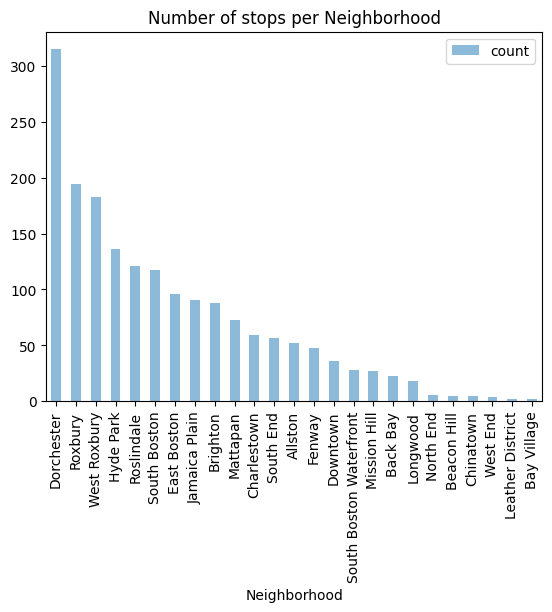

In [ ]:
Bus_stops['Neighborhood'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Number of stops per Neighborhood")
plt.show()

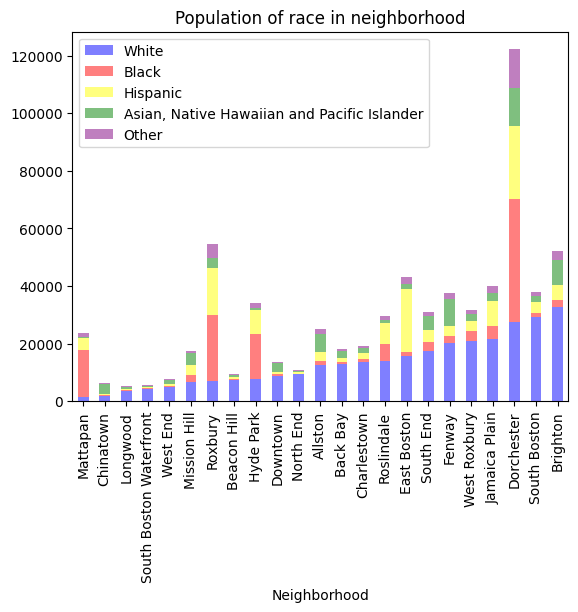

In [ ]:
stacked_df = Neighborhood_Ints_df.sort_values(by = ["White"])
# races = ["White alone", "Black or African American alone","Hispanic or Latino","Asian, Native Hawaiian and Pacific Islander alone, all ages", "Other Races or Multiple Races,  all ages" ]
ax = stacked_df.plot(kind = 'bar',x='Neighborhood', stacked=True, color=['blue','red','yellow','green','purple'],legend=True, alpha=.5)
plt.title("Population of race in neighborhood")
plt.show()

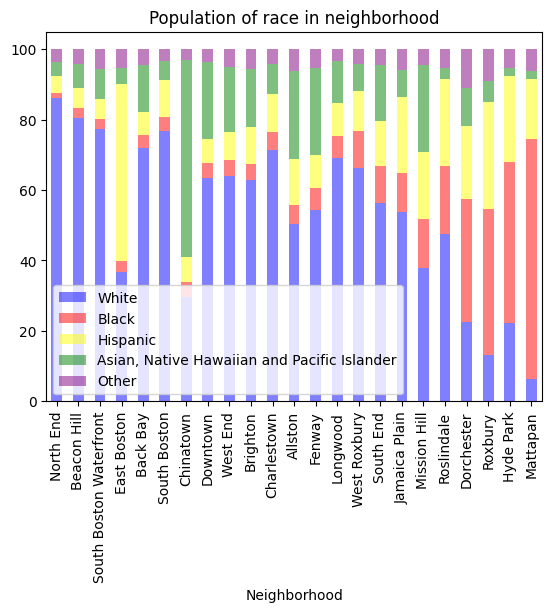

In [ ]:
stacked_percentage_df = Neighborhood_Percentages_df.sort_values(by = ["Black"])
# races = ["White alone", "Black or African American alone","Hispanic or Latino","Asian, Native Hawaiian and Pacific Islander alone, all ages", "Other Races or Multiple Races,  all ages" ]
ax = stacked_percentage_df.plot(kind = 'bar',x='Neighborhood', stacked=True, color=['blue','red','yellow','green','purple'],legend=True, alpha=.5)
plt.title("Population of race in neighborhood")
plt.show()

In [ ]:
Bus_stops = Bus_stops.loc[worst_on_time_routes]
merged = pd.merge(Bus_stops, Neighborhood_Percentages_df, left_on='Neighborhood', right_on='Neighborhood')
merged.head()


KeyError: "None of [Index(['14', '70A', '19', '701', '41', '747', '459', '448', '449', '9703'], dtype='object')] are in the [index]"

In [ ]:
average_neighborhood = merged.groupby('Routes')[['White', 'Black', 'Hispanic', 'Asian, Native Hawaiian and Pacific Islander', 'Other']].mean()
average_neighborhood.head()

,White,Black,Hispanic,"Asian, Native Hawaiian and Pacific Islander",Other
Routes,,,,,
1,34.158051,24.935417,20.861718,13.038985,7.005828
10,56.180430,10.545560,12.936837,15.774657,4.562516
104|105|109,71.265690,5.177824,10.852510,8.629707,4.074268
109|104|105,71.265690,5.177824,10.852510,8.629707,4.074268
10|170,61.395346,8.294805,10.838228,14.932784,4.538837


In [ ]:
average_neighborhood = merged.groupby('Routes')['Neighborhood']


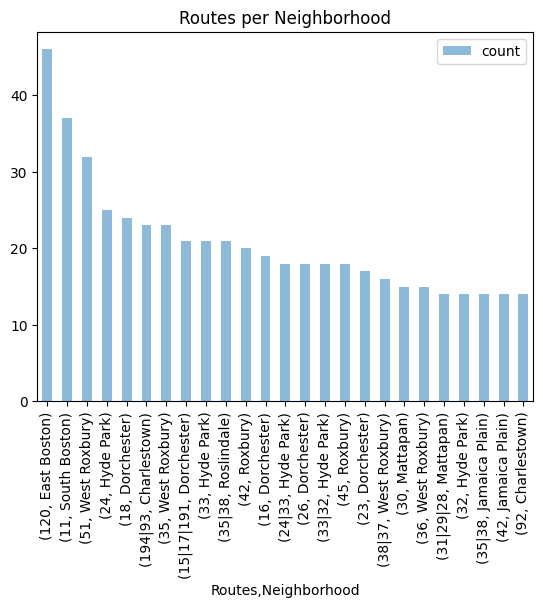

In [ ]:
average_neighborhood.value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Routes per Neighborhood")
plt.show()

In [1]:
# worst_on_time_routes = ['14', '70A', '19', '701', '41', '747', '459', '448', '449', '9703']

# worst_routes_neighborhood = average_neighborhood.loc[worst_on_time_routes]
